In [2]:
# Import af pakker

import ast
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import stanza
import nltk
from nltk.corpus import stopwords
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel

# Download ressourcer
#nltk.download('stopwords')
#stanza.download('da')

# Sæt visualiseringsindstillinger
%matplotlib inline
sns.set(rc={'figure.figsize':(20,10)})

# Sæt sprogmodel
nlp = stanza.Pipeline('da', processors = 'tokenize, pos, lemma')

2021-03-12 17:18:56 INFO: Loading these models for language: da (Danish):
| Processor | Package |
-----------------------
| tokenize  | ddt     |
| pos       | ddt     |
| lemma     | ddt     |

2021-03-12 17:18:56 INFO: Use device: cpu
2021-03-12 17:18:56 INFO: Loading: tokenize
2021-03-12 17:18:56 INFO: Loading: pos
2021-03-12 17:18:56 INFO: Loading: lemma
2021-03-12 17:18:56 INFO: Done loading processors!


# ØVELSE 1: Simpel teksthåndtering

I øvelserne i dag skal i arbejde med et datasæt bestående af kommentarer fra reddit. Alle kommentarer er taget fra posts på r/denmark (reddit.com/r/denmark) fra 1/3-8/3 2021.

1. Indlæs data som en pandas data frame
    - Link til data: https://raw.githubusercontent.com/CALDISS-AAU/course_ndms-I/master/datasets/reddit_rdenmark-comments_01032021-08032021_long.csv
2. Dan et subset bestående af alle kommentarer, der nævner "menneskerettigheder" (kommentarteksten er i kolonnen `comment_body`). Hvor mange kommentarer er der?

**Bonus**
- Kan du udregne gennemsnitsscore for de kommentarer, der nævner menneskerettigheder? (score fremgår af kolonnen `comment_score`)

In [9]:
# Indlæs data
redditdata_url = "https://raw.githubusercontent.com/CALDISS-AAU/course_ndms-I/master/datasets/reddit_rdenmark-comments_01032021-08032021_long.csv"
reddit_df = pd.read_csv(redditdata_url)

# Dan subset
reddit_hr = reddit_df.loc[reddit_df['comment_body'].str.contains("menneskerettigheder")]

# Antal kommentarer (svarer til antal rækker i subset)
print(reddit_hr.shape[0])

# Gennemsnitsscore
print(reddit_hr['comment_score'].mean())

11
35.45454545454545


# ØVELSE 2: Tokenization

Prøv at undersøge tekstindholdet af et af opslagene i redditdata: `post = reddit_df.loc[503, 'post_selftext']`

1. Tokenize opslaget - enten med en funktion eller trin for trin
2. Lav en ordoptælling ved at konvertere jeres tokens til en pandas series og bruge `.value_counts()`

In [10]:
# Inspicer opslag
post = reddit_df.loc[503, 'post_selftext']
print(post)

Til mods: emnet er relevant for subben, fordi danmark vil være påvirket af en verdenskrig, og det kunne være interresant med nogle diskussioner, om noget der har et meget bredt perspektiv. 

Indledning: Jeg læste for nyligt nogle tweets fra verdensledere og CEO's. Derudover har jeg researchet lidt om AI, så jeg er selvfølgelig ekspert nu /s. 

Nej, men det er ment som et seriøst debatindlæg, jeg siger ikke at følgende er den endegyldige sandhed, det er et debatindlæg, fordi jeg ved subben er fyldt til randen med IT-folk og politisk interreserede. Verdenssituationen er lige nu følgende: 

Efter en altødelæggende 2. verdenskrig, hvor Hitler ønskede at udvide sit 3. rige på bekostning af nabolandende, indstillede der sig en ligevægt efterfølgende, hvor landende var træt af krig, og hvor teknologien var nået så langt, at udsigten til en 3. verdenskrig kunne betyde enorme ødelæggelser som aldrig set før. Vi blev afhængige af hinanden økonomisk, og der blev oprettet konventioner og man lærte

In [27]:
# Tokenizer funktion (med nltk stopwords)
from nltk.corpus import stopwords

def tokenizer_basic(text):
    punct_list = [',', '-','.','?','!', ')']
    stop_words = list(stopwords.words('danish'))

    for punct in punct_list:
            text = text.replace(punct, "")
    
    words = text.lower().split(" ")

    tokens = []

    for word in words:
        if word not in stop_words:
            tokens.append(word)

    tokens = list(filter(None, tokens))

    return(tokens)

In [28]:
# Brug tokenizer
tokens = tokenizer_basic(post)

print(tokens)

['mods:', 'emnet', 'relevant', 'subben', 'fordi', 'danmark', 'påvirket', 'verdenskrig', 'interresant', 'diskussioner', 'bredt', 'perspektiv', '\n\nindledning:', 'læste', 'nyligt', 'tweets', 'verdensledere', "ceo's", 'derudover', 'researchet', 'lidt', 'ai', 'så', 'selvfølgelig', 'ekspert', '/s', '\n\nnej', 'ment', 'seriøst', 'debatindlæg', 'siger', 'følgende', 'endegyldige', 'sandhed', 'debatindlæg', 'fordi', 'ved', 'subben', 'fyldt', 'randen', 'itfolk', 'politisk', 'interreserede', 'verdenssituationen', 'lige', 'følgende:', '\n\nefter', 'altødelæggende', '2', 'verdenskrig', 'hitler', 'ønskede', 'udvide', '3', 'rige', 'bekostning', 'nabolandende', 'indstillede', 'ligevægt', 'efterfølgende', 'landende', 'træt', 'krig', 'teknologien', 'nået', 'så', 'langt', 'udsigten', '3', 'verdenskrig', 'betyde', 'enorme', 'ødelæggelser', 'aldrig', 'set', 'før', 'afhængige', 'hinanden', 'økonomisk', 'oprettet', 'konventioner', 'lærte', 'fortidens', 'fejl', '(hvilket', 'blandt', 'andet', 'unfair', 'vilkå

In [29]:
# Series konvertering og optælling

tokens_s = pd.Series(tokens)

tokens_s.value_counts()

så             8
ai             7
verdenskrig    5
kan            5
set            5
              ..
seriøst        1
eje            1
kulturelt      1
potentialet    1
udsigten       1
Length: 259, dtype: int64

# ØVELSE 3: Meningsfulde tokens med stanza

Prøv at undersøge tekstindholdet af samme reddit opslag som før, men denne gang med brug af `stanza`: `post = reddit_df.loc[503, 'post_selftext']`

1. Skriv en tokenizer funktion, der bruger `stanza`
2. Tokenize opslaget med funktionen
3. Lav igen en ordoptælling ved at konvertere jeres tokens til en pandas series og bruge `.value_counts()`

In [30]:
# Lagr opslag for sig
post = reddit_df.loc[503, 'post_selftext']

In [31]:
# Tokenizer med stanza

nlp = stanza.Pipeline('da', processors = 'tokenize, pos, lemma') 

def tokenizer_stanza(text): # Definerer funktion ud fra koden fra tidligere
    custom_stops = []
    stop_words = list(stopwords.words('danish')) + custom_stops
    pos_tags = ['PROPN', 'ADJ', 'NOUN']

    doc = nlp(text)

    tokens = []

    for sentence in doc.sentences:
        for word in sentence.words:
            if (len(word.lemma) < 2):
                continue
            if (word.pos in pos_tags) and (word.lemma not in stop_words):
                tokens.append(word.lemma)
                
    return(tokens)

2021-03-12 17:37:58 INFO: Loading these models for language: da (Danish):
| Processor | Package |
-----------------------
| tokenize  | ddt     |
| pos       | ddt     |
| lemma     | ddt     |

2021-03-12 17:37:58 INFO: Use device: cpu
2021-03-12 17:37:58 INFO: Loading: tokenize
2021-03-12 17:37:58 INFO: Loading: pos
2021-03-12 17:37:59 INFO: Loading: lemma
2021-03-12 17:37:59 INFO: Done loading processors!


In [32]:
# Brug tokenizer
tokens = tokenizer_stanza(post)

print(tokens)

['mods', 'emne', 'relevant', 'subben', 'danmark', 'verdenskrig', 'interresant', 'diskussion', 'bred', 'perspektiv', 'indledning', 'twe', 'verdensleder', 'CEO', 'AI', 'ekspert', 'seriøs', 'debatindlæg', 'endegyldig', 'sandhed', 'debatindlæg', 'subben', 'rande', 'IT-folk', 'verdenssituation', 'altødelæggende', '2.', 'verdenskrig', 'Hitler', '3.', 'rige', 'bekostning', 'nabolandende', 'ligevægt', 'efterfølgende', 'træt', 'krig', 'teknologi', 'udsigt', '3.', 'verdenskrig', 'enorm', 'ødelæggelse', 'afhængig', 'konvention', 'fortid', 'fejl', 'unfair', 'vilkår', 'krig', 'tabe', '1.', 'verdenskrig', 'krig', 'indirekte', 'måde', 'proxy-land', 'overvågning', 'kulturelt', 'verden', 'retning', 'rigtig', 'menneskelig', 'psykologi', 'Hitler/Pinky', 'Brain', 'mentalitet', 'al', 'al', 'al', 'god', 'velgående', 'dag', 'svær', 'herredøm', 'skak', 'teknologi', 'intellig', 'agencies', 'finger', 'data', 'afhængig', 'bomber', 'al', 'al', 'gang', 'incitament', 'stor', 'knap', 'overtag', 'verdensherredøm', 'm

In [33]:
# Series konvertering og optælling
tokens_s = pd.Series(tokens)

tokens_s.value_counts()

AI             7
al             7
verdenskrig    5
teknologi      5
udvikling      4
              ..
danmark        1
CEO            1
unik           1
1.             1
mangel         1
Length: 134, dtype: int64

# ØVELSE 4: Tidy text data (reddit data)

Du skal nu anvende din funktion fra før på alle kommentarerne i reddit datasættet (kolonnen `comment_body`)

1. Brug `.apply()` til at anvende din tokenizer funktion på hele reddit datasættet til at lave en tokens kolonne (det kan være en god ide lige at teste funktionen med en enkelt kommentar først)
2. Brug `.explode()` til at konvertere data til et tidy format
3. Brug `.value_counts()` til at optælle tokens
4. Undersøg, hvor mange gange coronavirus er nævnt (tænkt gerne synonymer med!)

In [34]:
# Tester tokenizer på kommentar
tokenizer_stanza(reddit_df.loc[0, 'comment_body'])

['svær', 'reel', 'opjustering', 'al', 'levering']

In [35]:
# Bruger tokenizer på hele kommentarkolonnen (i en kopie af data)
reddit_df_tokenized = reddit_df.copy()
reddit_df_tokenized['tokens'] = reddit_df_tokenized['comment_body'].apply(tokenizer_stanza)

In [39]:
# Evt. indlæs tokenized data
import ast
reddit_df_tokenized = pd.read_csv("https://raw.githubusercontent.com/CALDISS-AAU/course_ndms-I/master/datasets/reddit_rdenmark-comments_01032021-08032021_long_tokenized.csv")
reddit_df_tokenized['tokens'] = reddit_df_tokenized['tokens'].apply(ast.literal_eval)

In [42]:
# Gør data tidy
reddit_df_tidy = reddit_df_tokenized.explode('tokens')

# Optæl tokens
reddit_df_tidy['tokens'].value_counts()[0:20]

al          334
god         305
stor        248
år          233
folk        229
&gt         187
Danmark     161
lille       146
samme       141
gang        141
dag         132
tid         130
problem     129
menneske    124
sted        123
dansk       122
ting        121
land        117
hel         106
ny          105
Name: tokens, dtype: int64

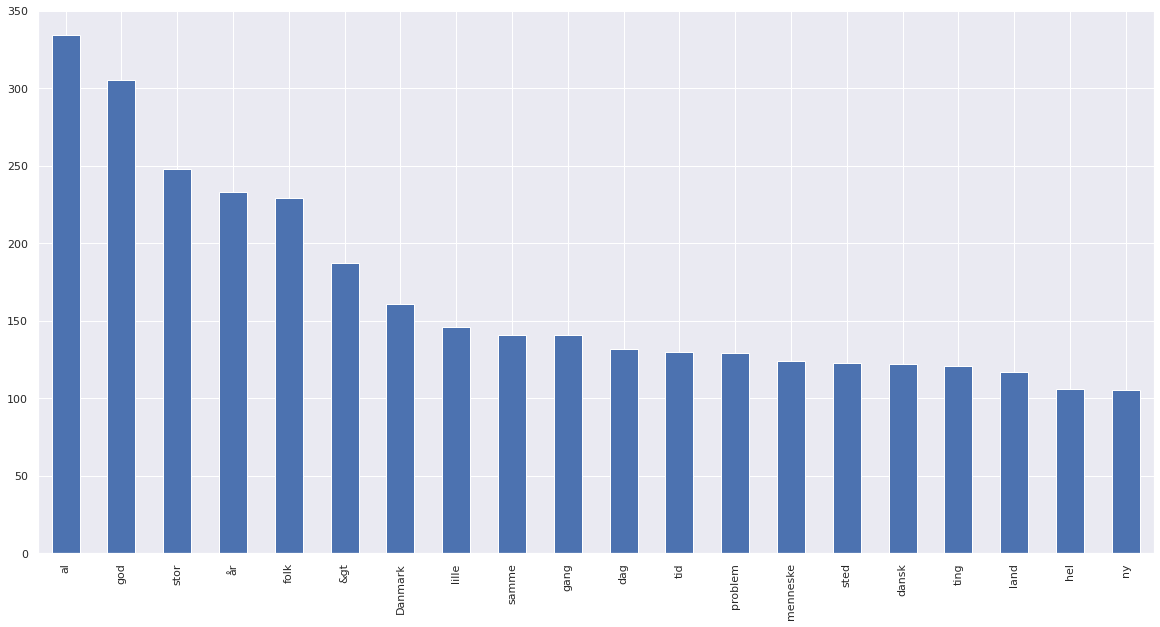

In [43]:
# Visualisering af top 20
reddit_df_tidy['tokens'].value_counts()[0:20].plot.bar()

In [45]:
# Optælling af coronaord

covid_ws = ['corona', 'coronavirus', 'covid', 'COVID', 'covid-19', 'COVID-19', 'covid19', 'COVID19']

reddit_covid = reddit_df_tidy.loc[reddit_df_tidy['tokens'].isin(covid_ws), :]

print(reddit_covid.shape[0])

24


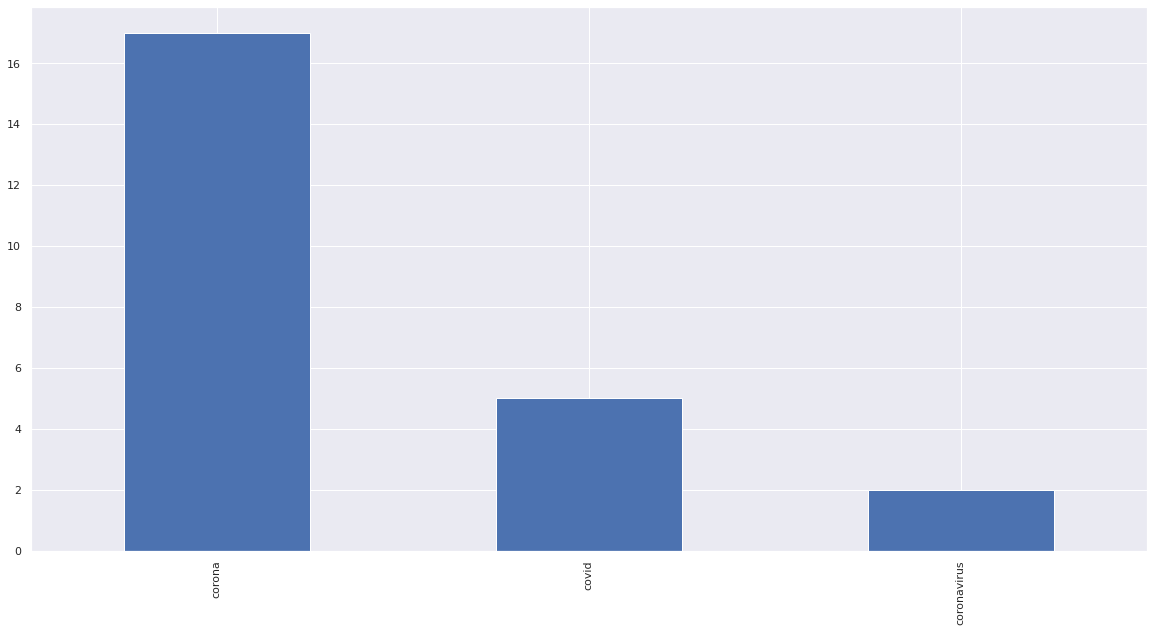

In [46]:
# Visualisering
reddit_covid['tokens'].value_counts().plot.bar()

# ØVELSE 5: Topic models i Python (reddit data)

I skal nu lave en topic model for reddit kommentarerne.

1. Dan et "gensim corpus" ud fra reddit kommentarerne (`comment_body`)
2. Dan en topic model over kommentarerne (bestem selv antal topics)
3. Inspicér de mest sandsynlige ord i hvert topic (`lda_model.show_topics(formatted=False)`)
4. Hvad kan I bruge modellen til?

In [47]:
# Lagr kommentar tokens i liste for sig
comment_tokens = list(reddit_df_tokenized['tokens'])

print(comment_tokens[0])

['svær', 'reel', 'opjustering', 'al', 'levering']


In [49]:
# Dan dictionary
from gensim import corpora

id2token = corpora.Dictionary(comment_tokens) # integer id per word

print(id2token)

Dictionary(8092 unique tokens: ['al', 'levering', 'opjustering', 'reel', 'svær']...)


In [51]:
# Danner gensim corpus - optælling af tokens per tekst
comment_corpus = [id2token.doc2bow(tokens) for tokens in comment_tokens] # bag-of-word(bow) tuples for hver text - (token-id, optælling)

print(comment_corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


In [72]:
# Kører topic model - 5 topics
from gensim.models.ldamodel import LdaModel

lda_model = LdaModel(corpus=comment_corpus,  # Corpus af tekster
                    id2word=id2token,       # Dictionary af ord-id mapping
                     num_topics=5,          # Antal topics
                     random_state=142)       # Sætter seed - sikrer samme resultat

In [73]:
# Checker ord i topics
from pprint import pprint

pprint(lda_model.show_topics(formatted=False)) # Viser de 10 mest sandsynlige ord per topic

[(0,
  [('indvandrer', 0.010818212),
   ('Danmark', 0.0065139174),
   ('år', 0.0062401583),
   ('stor', 0.0057198377),
   ('EU', 0.0042441385),
   ('befolkning', 0.0040589334),
   ('vand', 0.0039795367),
   ('al', 0.0038718502),
   ('par', 0.003767011),
   ('folk', 0.003766133)]),
 (1,
  [('god', 0.016062904),
   ('reklame', 0.010819281),
   ('stor', 0.009639357),
   ('folk', 0.008041313),
   ('[deleted]', 0.0074760593),
   ('al', 0.0073573138),
   ('gang', 0.0071729287),
   ('år', 0.006604641),
   ('samme', 0.0065232925),
   ('&gt', 0.0063476474)]),
 (2,
  [('al', 0.014740941),
   ('god', 0.010484116),
   ('folk', 0.008793021),
   ('dag', 0.008544035),
   ('år', 0.007585443),
   ('lille', 0.007471538),
   ('guld', 0.006958414),
   ('stor', 0.006847847),
   ('Israel', 0.005448176),
   ('hel', 0.005266357)]),
 (3,
  [('&gt', 0.0072892983),
   ('land', 0.0071063144),
   ('tak', 0.006359148),
   ('bog', 0.0060873036),
   ('krone', 0.005940039),
   ('dansk', 0.0059036985),
   ('al', 0.0058

In [95]:
# Brug LDA model på enkelt kommentar
from pprint import pprint
print(reddit_df_tokenized.loc[10, 'comment_body'])
print("\n")
print("---TOPICS---")
print("\n")
pprint(lda_model[comment_corpus[10]])

De er efter sigende ved at opgradere deres produktion... samme som Pfizer var ved.

Ikke desto mindre er det lidt slående, hvor lidt de har kunnet levere i forhold til. Man kan håbe, opgraderingen har en stor effekt.


---TOPICS---


[(0, 0.020699734),
 (1, 0.02057898),
 (2, 0.020475779),
 (3, 0.91763717),
 (4, 0.020608358)]


In [96]:
print(reddit_df_tokenized.loc[500, 'comment_body'])
print("\n")
print("---TOPICS---")
print("\n")
pprint(lda_model[comment_corpus[500]])

Jeg hilser på alle, ikke kun ældre. Hvis jeg får øjenkontakt, uanset med hvem, så hilser jeg. Enten ved at sige hej, eller med et venligt nik.  


Du har helt ret, det burde alle gøre.


---TOPICS---


[(0, 0.022558661),
 (1, 0.022511918),
 (2, 0.022911731),
 (3, 0.022435868),
 (4, 0.90958184)]
